投票结果：
C0: 115
C1: 16
C2: 69


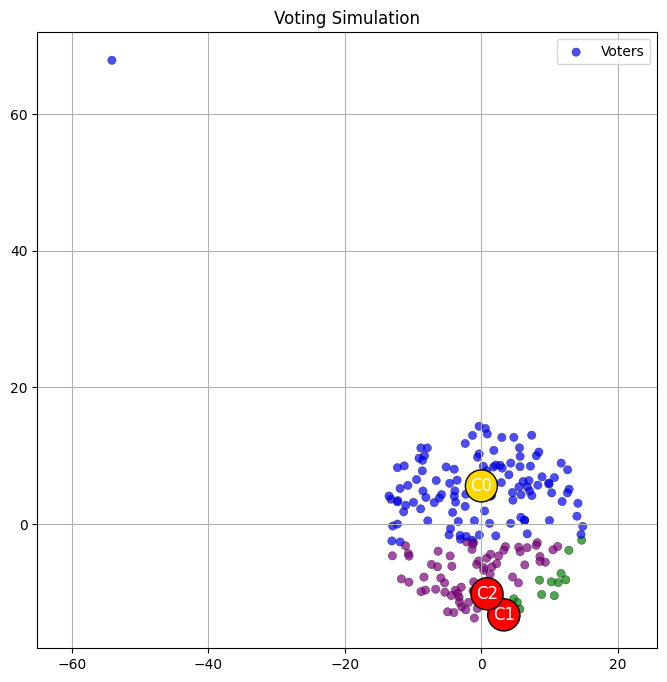

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

class VotingSimulation:
    def __init__(self,
                 num_voters=100,
                 num_candidates=3,
                 center=np.array([0, 0]),
                 spread_radius=10,
                 dimension=2):
        """
        num_voters:         选民总数
        num_candidates:     候选人/提案总数（至少 2）
        center:             选民/候选人生成的中心点（默认为 [0,0]）
        spread_radius:      生成时的“半径”范围
        dimension:          维度（暂时只支持 2维可视化）
        """
        self.num_voters = num_voters
        self.num_candidates = num_candidates
        self.center = np.array(center)
        self.spread_radius = spread_radius
        self.dimension = dimension

        # 一初始化就把选民和候选人的位置生成好
        self.voters = self._generate_voters()
        self.candidates = self._generate_candidates()
        self.votes = None  # 用来存储每个选民投给哪个候选人（索引）

    def _generate_voters(self):
        """
        在“圆形范围”内随机生成 (num_voters - 1) 个点，再用最后一个点补偿，
        使得所有点的质心（向量和）落在 center 上。
        """
        # 先随机产生 N-1 个点，角度均匀，半径服从 sqrt{Uniform(0,1)} * spread_radius
        angles = np.random.uniform(0, 2 * np.pi, self.num_voters - 1)
        radii = np.sqrt(np.random.uniform(0, 1, self.num_voters - 1)) * self.spread_radius
        x = radii * np.cos(angles)
        y = radii * np.sin(angles)
        raw = np.column_stack([x, y])

        # 让最后一个点等于前面所有点向量和的相反数，确保质心在 (0,0)，再整体平移到 center
        last = -np.sum(raw, axis=0)
        voters = np.vstack([raw, last]) + self.center
        return voters

    def _generate_candidates(self):
        """
        在同样的“圆形半径”内随机生成 num_candidates 个候选人，
        （候选人不需要质心为 0，直接每个点都服从均匀圆形即可）
        """
        angles = np.random.uniform(0, 2 * np.pi, self.num_candidates)
        radii = np.sqrt(np.random.uniform(0, 1, self.num_candidates)) * self.spread_radius
        x = radii * np.cos(angles)
        y = radii * np.sin(angles)
        return np.column_stack([x, y]) + self.center

    def vote(self):
        """
        让每个选民计算自己到各候选人的欧几里得距离，
        把索引最小（距离最近）的那位的编号记下来。
        """
        # voters.shape = (num_voters, 2)，candidates.shape = (num_candidates, 2)
        # 计算 (num_voters, num_candidates) 的距离矩阵
        distances = np.linalg.norm(self.voters[:, np.newaxis, :] - 
                                   self.candidates[np.newaxis, :, :], axis=2)
        # argmin 得到每个选民投票给哪个候选人的索引
        self.votes = np.argmin(distances, axis=1)
        return self.votes

    def get_vote_count(self):
        """
        返回一个 Counter，key=候选人索引，value=得票数。
        如果还没投票，就先自动调用 vote()。
        """
        if self.votes is None:
            self.vote()
        return Counter(self.votes)

    def plot(self):
        """
        1. 强制以选民重心为中心，设置显示范围：max(所有点相对重心的 x/y 偏移) + 边距。
        2. 用不同颜色标出每个选民投给哪个候选人。
        3. 把得票最多的候选人单独用“金色”标记，其余候选人用红色。
        4. 绘完图自动显示坐标网格、图例、标题等。
        """
        if self.dimension != 2:
            print("目前仅支持二维可视化")
            return

        # 如果还没投票，就先投一轮
        if self.votes is None:
            self.vote()

        plt.figure(figsize=(8, 8))

        # ***********************
        # （A）为选民着色：每个选民根据 votes[i] 决定颜色
        #    这里预设了几个颜色循环：blue, green, purple, …
        cmap = ['blue', 'green', 'purple', 'orange', 'cyan', 'magenta']
        vote_colors = [cmap[v % len(cmap)] for v in self.votes]
        plt.scatter(self.voters[:, 0], self.voters[:, 1],
                    c=vote_colors, label='Voters',
                    alpha=0.7, edgecolors='black', linewidths=0.3)

        # ***********************
        # （B）计算“选民重心”
        voter_center = np.mean(self.voters, axis=0)

        # ***********************
        # （C）计算所有点（选民 + 候选人）相对于重心的最大偏移
        all_points = np.vstack([self.voters, self.candidates])
        deviations = np.abs(all_points - voter_center)  # shape = (num_voters+num_candidates, 2)
        max_dev = np.max(deviations, axis=0)            # [max_dx, max_dy]
        half_range = max(max_dev[0], max_dev[1])        # 选 x,y 两方向里最大偏移
        margin = self.spread_radius * 0.2               # 给个 20% 的额外边距
        display_range = half_range + margin

        # ***********************
        # （D）找出“获胜候选人”的索引
        counts = self.get_vote_count()
        # 如果是并列得票，这里会挑索引最小的那个；也可以按需改成并列处理
        winner = max(range(self.num_candidates), key=lambda i: counts.get(i, 0))

        # ***********************
        # （E）绘制候选人：赢家用金色（gold），其余用红色
        for idx, candidate in enumerate(self.candidates):
            if idx == winner:
                color = 'gold'
            else:
                color = 'red'
            plt.scatter(candidate[0], candidate[1],
                        c=color, marker='X', s=150)
            plt.text(candidate[0], candidate[1], f'C{idx}',
                     fontsize=12, ha='center', va='center',
                     color='white',
                     bbox=dict(facecolor=color,
                               edgecolor='black',
                               boxstyle='circle,pad=0.3'))

        # ***********************
        # （F）强制设置坐标轴范围：以选民重心为中心，± display_range
        plt.xlim(voter_center[0] - display_range, voter_center[0] + display_range)
        plt.ylim(voter_center[1] - display_range, voter_center[1] + display_range)

        plt.title("Voting Simulation")
        plt.grid(True)
        plt.legend()
        plt.axis('equal')
        plt.show()

# 模拟：200 名选民、3 个候选人，半径 15
sim = VotingSimulation(num_voters=200, num_candidates=3, spread_radius=15)
sim.vote()

# 按行打印各提案票数，格式：C0: xx, C1: yy, C2: zz
print("投票结果：")
counts = sim.get_vote_count()
for i in range(sim.num_candidates):
    print(f"C{i}: {counts.get(i, 0)}")

# 绘制图像
sim.plot()
